In [1]:
import sys
sys.path.append("../..")
import torch
import numpy as np
import matplotlib.pyplot as plt
from data_utils      import *
from model_utils     import get_network
from tqdm import tqdm
from torchvision import transforms as T
from copy import deepcopy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# create dataloaders
channel, im_size, train_n_classes, test_n_classes, dst_train, dst_test = get_dataset(
        "CIFAR10",
        "../../data",
        zca=False
    )
assert train_n_classes == test_n_classes
train_loader = torch.utils.data.DataLoader(dst_train, batch_size=256, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(dst_test, batch_size=256, shuffle=False, num_workers=8)

inv_transform = T.Compose([ T.ToTensor(), T.Normalize(mean = [ 0., 0., 0. ],
                                std = [ 1/0.2023, 1/0.1994, 1/0.2010 ]),
                            T.Normalize(mean = [ -0.4914, -0.4822, -0.4465 ],
                                std = [ 1., 1., 1. ]),
                        ])

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# store test data for faster inference (run on RTX 3090 with 24GB of VRAM)
test_label = []
test_img = []
with torch.no_grad():
    for x, y in tqdm(test_loader):
        test_label.append(y)
        test_img.append(x)
test_label = torch.hstack(test_label).to(device)
test_img = torch.vstack(test_img).to(device)
print(test_img.shape)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 47.81it/s]


torch.Size([10000, 3, 32, 32])


In [4]:
index = 0 # distilled data used to calculate influence
data = torch.load(f"../../DD_data/{index}.pt")
synthetic_data = data["data"].to(device)
synthetic_label = data["label"].to(device)

ref_model = get_network("ConvNet", 3, 10, (32,32)).to(device)

In [5]:
total_losses = []
total_correct = []
for i in tqdm(range(101)):
    mask = np.ones(100, dtype=bool)
    if i < 100:
        mask[i] = False
    sdata = synthetic_data[mask, :, :, :]
    slabel = synthetic_label[mask]
    torch.manual_seed(1)
    model = deepcopy(ref_model)
    optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = torch.nn.CrossEntropyLoss()
    model.train()
    for e in range(300):
        pred = model(sdata)
        loss = criterion(pred[-1], slabel)
        optim.zero_grad()
        loss.backward()
        optim.step()

    criterion2 = torch.nn.CrossEntropyLoss(reduction='none')
    model.eval()
    with torch.no_grad():
        losses = []
        correct = []
        for x,y in test_loader:
            x = x.to(device)
            y = y.to(device)
            pred = model(x)[-1]
            losses.append(criterion2(pred, y))
            correct.append(torch.argmax(pred, dim=1) == y)
        losses = torch.hstack(losses)
        correct = torch.hstack(correct)
    total_losses.append(losses)
    total_correct.append(correct)
total_losses = torch.vstack(total_losses)
print(total_losses.shape)

100%|████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:44<00:00,  1.63s/it]

torch.Size([101, 10000])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0, 'BPTT')

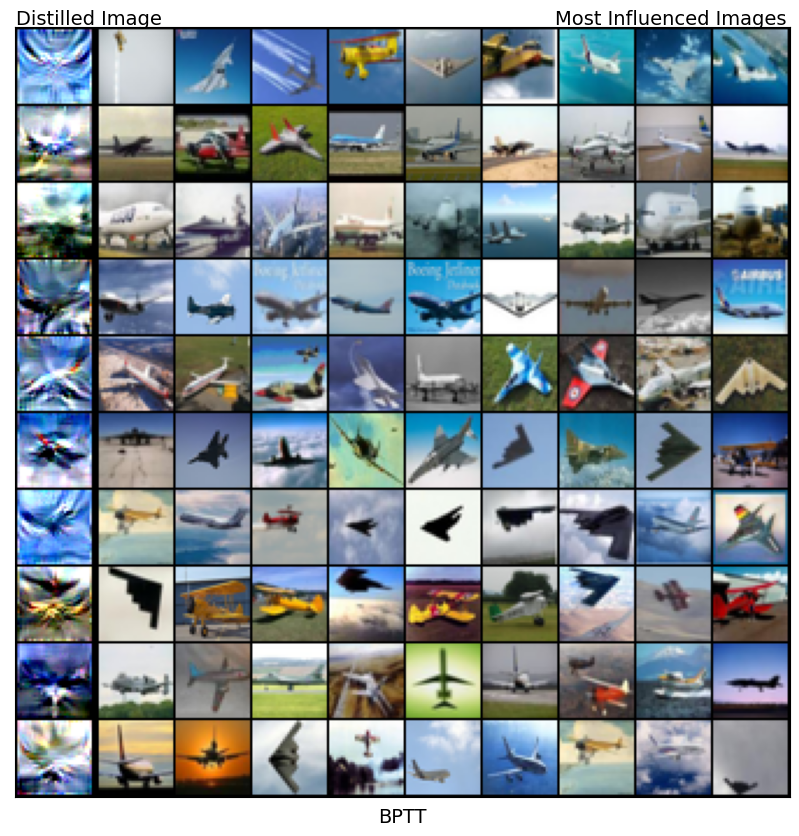

In [6]:
influences = total_losses[:100,:] - total_losses[100:,:]

plt.figure(figsize=(25,10))
offset = 0 # offset by class, 0 - airplane, 1 - cars, etc
distilled_image = []
example_image = []
for k in range(10):
    j = offset*10 + k
    if k == 0:
        pad = T.Pad((1,1,2,1), fill=0)
    else:
        pad = T.Pad((1,0,2,1), fill=0)
    distilled_image.append(np.clip(np.array(pad(inv_transform(synthetic_data[j:(j+1),:].reshape(1,3,32,32).squeeze(0).detach().cpu().numpy().transpose(1,2,0)))).transpose(1,2,0), 0, 1))

    inf = influences[j,:].cpu().numpy()
    idx = np.argsort(inf)[::-1]

    stacked = []
    for i in range(9):
        if i == 0 and k == 0:
            pad2 = T.Pad(1, fill=0)
        elif i == 0:
            pad2 = T.Pad((1,0,1,1), fill=0)
        elif i !=0 and k == 0:
            pad2 = T.Pad((0,1,1,1), fill=0)
        else:
            pad2 = T.Pad((0,0,1,1), fill=0)
        stacked.append(pad2(inv_transform(test_img[idx[i], :, :, :].cpu().numpy().reshape(1,3,32,32).squeeze(0).transpose(1,2,0))))
    example_image.append((np.array(torch.concat(stacked, dim=2)).transpose(1,2,0)))
    
distilled_image = np.concatenate(distilled_image, axis=0)
example_image = np.concatenate(example_image, axis=0)
plt.xticks([])
plt.yticks([])
plt.imshow(np.concatenate([distilled_image, example_image], axis=1))
plt.text(0, -8, 'Distilled Image', color='black', fontsize=14, verticalalignment='top', horizontalalignment='left')
plt.text(331, -8, 'Most Influenced Images', color='black', fontsize=14, verticalalignment='top', horizontalalignment='right')
plt.xlabel("BPTT", fontsize=14)